In [38]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import random
from sklearn.model_selection import train_test_split

transform = transforms.ToTensor()


# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
# test_data = datasets.MNIST(root='data', train=False,
#                                   download=True, transform=None)

In [39]:
# # Create training and test dataloaders

# num_workers = 0
# # how many samples per batch to load
# batch_size = 20

# # prepare data loaders
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [40]:

# regtarget=1
# anomalytarget=3
# contam=0.01
# seed=42


# regIdxs = np.where(targets == regtarget)[0]
# anomalyIdxs = np.where(targets == anomalytarget)[0]

# # randomly shuffle both sets of indexes
# np.random.seed(42)
# np.random.shuffle(regIdxs)
# np.random.shuffle(anomalyIdxs)

# # compute the total number of anomaly data points to select
# i = int(len(regIdxs) * contam)
# anomalyIdxs = anomalyIdxs[:i]

# # use NumPy array indexing to extract both the valid images and
# # "anomlay" images
# regImages = data[regIdxs]
# anomalyImages = data[anomalyIdxs]

# # stack the valid images and anomaly images together to form a
# # single data matrix and then shuffle the rows
# images = np.vstack([regImages, anomalyImages])
# np.random.seed(seed)
# np.random.shuffle(images)


In [41]:
def create_unsupervised_dataset(data, targets, regtarget=1,
    anomalytarget=3, contam=0.01, seed=42):
    # grab all indexes of the supplied class label that are *truly*
    # that particular label, then grab the indexes of the image
    # labels that will serve as our "anomalies"
    regIdxs = np.where(targets == regtarget)[0]
    anomalyIdxs = np.where(targets == anomalytarget)[0]

    # randomly shuffle both sets of indexes
    np.random.seed(42)
    np.random.shuffle(regIdxs)
    np.random.shuffle(anomalyIdxs)

    # compute the total number of anomaly data points to select
    i = int(len(regIdxs) * contam)
    anomalyIdxs = anomalyIdxs[:i]

    # use NumPy array indexing to extract both the valid images and
    # "anomlay" images
    regImages = data[regIdxs]
    anomalyImages = data[anomalyIdxs]

    # stack the valid images and anomaly images together to form a
    # single data matrix and then shuffle the rows
    images = np.vstack([regImages, anomalyImages])
    np.random.seed(seed)
    np.random.shuffle(images)

    # return the set of images
    return images

In [42]:
data = train_data.data.cpu().numpy()
targets = train_data.targets.cpu().numpy()

images = create_unsupervised_dataset(data,targets)

X_train, X_valid = train_test_split(images, test_size=0.2,random_state=42)

In [50]:
### CREATE CUSTOM PyTorch DATSET CLASS FOR OUT PARTICULAR DATSET ###

import torch
import torchvision
from torch.utils.data import Dataset
class MNISTAnomalyDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.X = np.uint8(X)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        
        if self.transform:
             sampleX = self.transform(self.X[idx])

        sample = (sampleX)



        return sample

In [51]:
from torchvision import transforms
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

data = {}

data['train'] = MNISTAnomalyDataset(X_train, transform=transform)
data['valid'] = MNISTAnomalyDataset(X_valid, transform=transform)

loaders = {}

batch_size=32

loaders['train'] = torch.utils.data.DataLoader(data['train'], batch_size=32, num_workers=0, shuffle=True)
loaders['valid'] = torch.utils.data.DataLoader(data['valid'], batch_size=32, num_workers=0)

(32, 1, 28, 28)


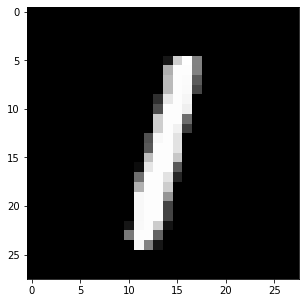

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(loaders['train'])
images = dataiter.next()
images = images.numpy()
print(images.shape)
# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [63]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = F.sigmoid(self.conv_out(x))
                
        return x

# initialize the NN
model = ConvAutoEncoder()

use_cuda = torch.cuda.is_available()
if use_cuda:
    model_transfer = model.cuda()
print(model)

ConvAutoEncoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [64]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data = data.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model.forward(data)
            loss = criterion(output,data)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            for batch_idx, (data) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data = data.cuda()
                ## update the average validation loss
                
                output = model.forward(data)
                loss = criterion(output,data)
                
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            
            
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [65]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [66]:
# train the model
n_epochs = 60
model_transfer =  train(n_epochs, loaders, model, optimizer, criterion, use_cuda, 'conv_Autoencoder_anomaly_adam_lr0001.pt')

C:\Users\admin\Anaconda3\envs\dlnanodegree\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.094278 	Validation Loss: 0.065671
Validation loss decreased (inf --> 0.065671).  Saving model ...
Epoch: 2 	Training Loss: 0.065990 	Validation Loss: 0.065669
Validation loss decreased (0.065671 --> 0.065669).  Saving model ...
Epoch: 3 	Training Loss: 0.066097 	Validation Loss: 0.065668
Validation loss decreased (0.065669 --> 0.065668).  Saving model ...
Epoch: 4 	Training Loss: 0.066068 	Validation Loss: 0.065668
Validation loss decreased (0.065668 --> 0.065668).  Saving model ...
Epoch: 5 	Training Loss: 0.066076 	Validation Loss: 0.065668
Validation loss decreased (0.065668 --> 0.065668).  Saving model ...
Epoch: 6 	Training Loss: 0.066073 	Validation Loss: 0.065668
Validation loss decreased (0.065668 --> 0.065668).  Saving model ...
Epoch: 7 	Training Loss: 0.066088 	Validation Loss: 0.065668
Validation loss decreased (0.065668 --> 0.065668).  Saving model ...
Epoch: 8 	Training Loss: 0.066022 	Validation Loss: 0.065668
Validation loss decreased (0.06566

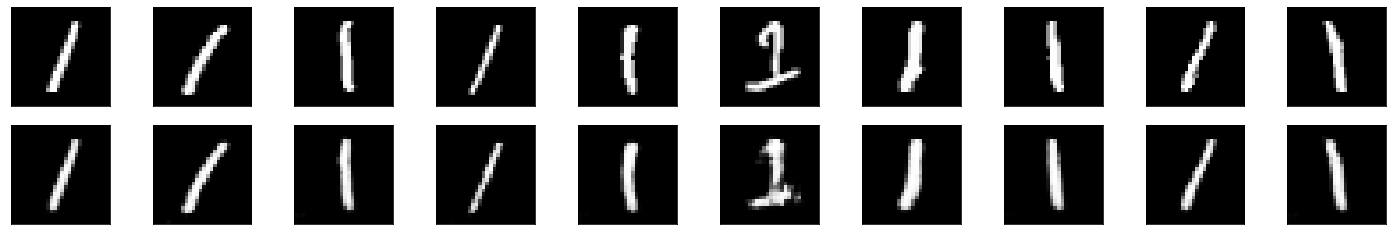

In [72]:
# obtain one batch of test images
dataiter = iter(loaders['valid'])
images = dataiter.next()
if use_cuda:
    images = images.cuda()
# get sample outputs
output = model(images)
# prep images for display
images = images.cpu().numpy()
batch_size = 32
# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)